In [34]:
import tensorflow as tf

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time

from IPython import display

In [36]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [37]:
file_path = r"/content/drive/My Drive/AI/data/images/Claude Monet"

In [38]:
def summary():
    for entry in os.scandir(file_path):
        if (entry.path.endswith(".jpg") and entry.is_file()):
            print(entry.path)
            image = Image.open(entry.path)
            print(f"Format ---> {image.format}")
            print(f"Mode ---> {image.mode}")
            print(f"SIZE ---> {image.size}")

            pixels = np.asarray(image)
            print(f'Data Type: {pixels.dtype}')
            print('Min: %.2f, Max: %.2f' % (pixels.min(), pixels.max()))
            print('MEAN: %.2f' % (pixels.mean()))
            
            print("AFTER NORMALIZATION")
            pixels = pixels.astype('float32')
            pixels /= 255.0
            print('Min: %.2f, Max: %.2f' % (pixels.min(), pixels.max()))
            print('MEAN: %.2f' % (pixels.mean()))

            # global centering of data (set mean at 0)
            print("AFTER CENTERING")
            pixels.mean()
            pixels -= pixels.mean()
            print('Min: %.2f, Max: %.2f' % (pixels.min(), pixels.max()))
            print('MEAN: %.2f' % (pixels.mean()))
            print()

In [39]:
summary()

/content/drive/My Drive/AI/data/images/Claude Monet/Agapanthus.jpg
Format ---> JPEG
Mode ---> RGB
SIZE ---> (128, 128)
Data Type: uint8
Min: 26.00, Max: 255.00
MEAN: 114.73
AFTER NORMALIZATION
Min: 0.10, Max: 1.00
MEAN: 0.45
AFTER CENTERING
Min: -0.35, Max: 0.55
MEAN: -0.00

/content/drive/My Drive/AI/data/images/Claude Monet/jardinjpg.jpg
Format ---> JPEG
Mode ---> RGB
SIZE ---> (128, 128)
Data Type: uint8
Min: 0.00, Max: 255.00
MEAN: 121.90
AFTER NORMALIZATION
Min: 0.00, Max: 1.00
MEAN: 0.48
AFTER CENTERING
Min: -0.48, Max: 0.52
MEAN: -0.00

/content/drive/My Drive/AI/data/images/Claude Monet/Bordighera.jpg
Format ---> JPEG
Mode ---> RGB
SIZE ---> (128, 128)
Data Type: uint8
Min: 0.00, Max: 225.00
MEAN: 91.16
AFTER NORMALIZATION
Min: 0.00, Max: 0.88
MEAN: 0.36
AFTER CENTERING
Min: -0.36, Max: 0.52
MEAN: -0.00

/content/drive/My Drive/AI/data/images/Claude Monet/iris.jpg
Format ---> JPEG
Mode ---> RGB
SIZE ---> (128, 128)
Data Type: uint8
Min: 0.00, Max: 255.00
MEAN: 80.32
AFTER NORMA

In [40]:
def get_image_data(im_path):
  image = Image.open(im_path).convert('L')
  pixels = np.asarray(image)
  # Normalization
  pixels = pixels.astype('float32')
  pixels /= 127.5

  # global centering of data (set mean at 0)

  pixels.mean()
  pixels -= 127.5
  return pixels

In [41]:
train_images = []

for entry in os.scandir(file_path):
        if (entry.path.endswith(".jpg") and entry.is_file()):
          img = get_image_data(entry.path)
          train_images.append(img)


train_images = np.array(train_images)

train_images = train_images.reshape(train_images.shape[0], 128, 128, 1).astype('float32')


In [42]:
get_image_data("/content/drive/My Drive/AI/data/images/Claude Monet/dame_im_garten.jpg")

array([[-127.20196 , -127.23333 , -127.194115, ..., -126.33922 ,
        -126.36275 , -126.37843 ],
       [-127.21764 , -127.29608 , -127.28824 , ..., -126.354904,
        -126.38628 , -126.40196 ],
       [-127.14706 , -127.23333 , -127.23333 , ..., -126.37843 ,
        -126.409805, -126.433334],
       ...,
       [-126.9902  , -127.02157 , -127.0451  , ..., -126.9902  ,
        -126.958824, -126.91961 ],
       [-127.037254, -127.06078 , -127.06863 , ..., -126.97451 ,
        -126.95098 , -126.91961 ],
       [-127.05294 , -127.06078 , -127.05294 , ..., -127.00588 ,
        -126.98235 , -126.95098 ]], dtype=float32)

# **Model**

The model (por ahora) will be a simple generator-discriminator model, with maxpooling and standart sampling (this is for testing only)

In [43]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))
    assert model.output_shape == (None, 32, 32, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

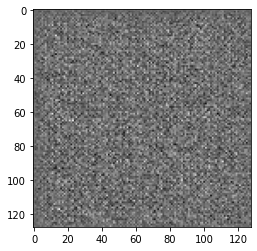

In [44]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [45]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [46]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00078372]], shape=(1, 1), dtype=float32)


In [47]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [48]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [49]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [50]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [51]:
checkpoint_dir = '/content/drive/My Drive/AI/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [52]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [53]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

DATASET PREPARATION

In [54]:
BUFFER_SIZE = 60000
BATCH_SIZE = 16

In [55]:
def train(epochs, dataset):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [56]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [57]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

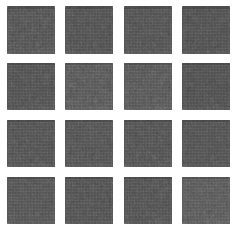

Time for epoch 169 is 1.4823665618896484 sec


In [ ]:
train(EPOCHS, train_dataset)